# Iceberg Classification using Deep Learning

The remote sensing systems used to detect icebergs are housed on satellites over 600 kilometers above the Earth. The Sentinel-1 satellite constellation is used to monitor Land and Ocean. Orbiting 14 times a day, the satellite captures images of the Earth's surface at a given location, at a given instant in time. The C-Band radar operates at a frequency that "sees" through darkness, rain, cloud and even fog. Since it emits it's own energy source it can capture images day or night.

<div style="display: flex; width: 100%;">
    <div style="float:left;width:50%;padding: 5px;"><img  style="height:300px;" src="./assets/satellite.jpg"></div>
    <div style="float:left;width:50%;padding: 5px;"><img style="height:300px;" src="./assets/iceberg.jpg"></div>
</div>

Satellite radar works in much the same way as blips on a ship or aircraft radar. It bounces a signal off an object and records the echo, then that data is translated into an image. An object will appear as a bright spot because it reflects more radar energy than its surroundings, but strong echoes can come from anything solid - land, islands, sea ice, as well as icebergs and ships. The energy reflected back to the radar is referred to as backscatter.

<img style="height: 300px" src="./assets/icebergs_and_ships.png">

When the radar detects a object, it can't tell an iceberg from a ship or any other solid object. The object needs to be analyzed for certain characteristics - shape, size and brightness - to find that out. The area surrounding the object, in this case ocean, can also be analyzed or modeled. Many things affect the backscatter of the ocean or background area. High winds will generate a brighter background. Conversely, low winds will generate a darker background. The Sentinel-1 satellite is a side looking radar, which means it sees the image area at an angle (incidence angle). Generally, the ocean background will be darker at a higher incidence angle. You also need to consider the radar polarization, which is how the radar transmits and receives the energy. More advanced radars like Sentinel-1, can transmit and receive in the horizontal and vertical plane. Using this, you can get what is called a dual-polarization image.

<img style="height: 300px;" src="./assets/plane.png">

For this classifier, we will use data with only two channels: HH (transmit/receive horizontally) and HV (transmit horizontally and receive vertically). This can play an important role in the object characteristics, since objects tend to reflect energy differently. Easy classification examples are see below. These objects can be visually classified. But in an image with hundreds of objects, this is very time consuming. 

<img src="./assets/iceberg_sat_data.png" style="height: 200px; width:800px;">
<img src="./assets/ship_sat_data.png" style="height: 200px; width:800px;">

Here we se challenging objects to classify

<img src="./assets/unclassifiable_data_1.png" style="height: 200px; width:800px;">
<img src="./assets/unclassifiable_data_2.png" style="height: 200px; width:800px;">

Humans can’t possibly classify such objects. Therefore in this project we will try to automate this task by applying complex Deep Learning algorithms, a Convolutional Neural Network in this case to classify these objects.

### This classification problem will be solved in three steps:
    1. Understanding the data and creating the train and test sets
    2. Developing the Neural Net model
    3. Training the model and evaluating it with tests

### Step 1: Understanding the data and creating the train and test sets

In [4]:
import numpy as np
import pandas as pd
import cv2
np.random.seed(1337)

df_train = pd.read_json('./data/train.json') # Reading the train data into a Pandas dataframe
df_train.head(10)

ModuleNotFoundError: No module named 'cv2'

In [5]:
df_train.describe()

NameError: name 'df_train' is not defined

In [ ]:
def get_scaled_imgs(df):
    """
    This function creates a 1604x75x75x2 array where 1604 is the number of training examples
    and 75x75x2 is a two channel image created by stacking the band_1 and band_2 values.
    """
    imgs = []
    
    for i, row in df.iterrows():
        # make a 75x75 image
        band_1 = np.array(row['band_1']).reshape(75, 75)
        band_2 = np.array(row['band_2']).reshape(75, 75)
        #band_3 = band_1 + band_2 # plus since log(x*y) = log(x) + log(y)
        
        # Rescale
        a = (band_1 - band_1.mean()) / (band_1.max() - band_1.min())
        b = (band_2 - band_2.mean()) / (band_2.max() - band_2.min())
        #c = (band_3 - band_3.mean()) / (band_3.max() - band_3.min())

        #imgs.append(np.dstack((a, b, c)))
        imgs.append(np.dstack((a, b)))

    return np.array(imgs)



In [ ]:
Xtrain = get_scaled_imgs(df_train)
Ytrain = np.array(df_train['is_iceberg'])

df_train.inc_angle = df_train.inc_angle.replace('na',0) # Replacing angle 'na' with 0
idx_tr = np.where(df_train.inc_angle>0) # indices where angle is greater than 0

Ytrain = Ytrain[idx_tr[0]]
Xtrain = Xtrain[idx_tr[0],...]

In [ ]:
def get_more_images(imgs):
    """
    This function created more training images by manipulating the current training images
    and performing transformations like flipping them vertically and horizontally
    """
    more_images = []
    vert_flip_imgs = []
    hori_flip_imgs = []
      
    for i in range(0,imgs.shape[0]):
        a=imgs[i,:,:,0]
        b=imgs[i,:,:,1]
        #c=imgs[i,:,:,2]
        
        av=cv2.flip(a,1)
        ah=cv2.flip(a,0)
        bv=cv2.flip(b,1)
        bh=cv2.flip(b,0)
        #cv=cv2.flip(c,1)
        #ch=cv2.flip(c,0)
        
        #vert_flip_imgs.append(np.dstack((av, bv, cv)))
        vert_flip_imgs.append(np.dstack((av, bv)))
        #hori_flip_imgs.append(np.dstack((ah, bh, ch)))
        hori_flip_imgs.append(np.dstack((ah, bh)))
      
    v = np.array(vert_flip_imgs)
    h = np.array(hori_flip_imgs)
       
    more_images = np.concatenate((imgs,v,h))
    
    return more_images

Xtr_more = get_more_images(Xtrain)
Ytr_more = np.concatenate((Ytrain,Ytrain,Ytrain))


In [3]:
# So now we have total training samples as
len(Xtr_more)

NameError: name 'Xtr_more' is not defined

In [7]:
%matplotlib inline
#Take a look at a iceberg
import plotly.offline as py
import plotly.graph_objs as go

py.init_notebook_mode(connected=True)
#py.offline.init_notebook_mode(connected=True)

def plotmy3d(c, name):
    
    data = [
        go.Surface(
            z=c
        )
    ]
    
    layout = go.Layout(
        title=name,
        autosize=False,
        width=700,
        height=700,
        margin=dict(
            l=65,
            r=50,
            b=65,
            t=90
        )
    )
    fig = go.Figure(data=data, layout=layout)
    py.iplot(fig)

In [8]:
# Creating X_band_1 array for plotting
X_band_1 = np.array([np.array(band).astype(np.float32).reshape(75,75) for band in df_train['band_1']])

In [1]:
plotmy3d(X_band_1[5,:,:], 'iceberg')

NameError: name 'plotmy3d' is not defined

In [10]:
plotmy3d(X_band_1[4,:,:], 'Ship')

### Step 2: Developing a Neural Network Model

In [11]:
# Import Keras 
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Activation
from keras.layers import Conv2D, MaxPooling2D
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras.layers.normalization import BatchNormalization
from keras.optimizers import Adam

def getModel():
    """
    This function builds a Convolutional Neural Network model with 4 convolution layers and
    3 dense layers
    """
    
    model=Sequential()
    
    # CNN 1
    #model.add(Conv2D(64, kernel_size=(3, 3),activation='relu', input_shape=(75, 75, 3)))
    model.add(Conv2D(64, kernel_size=(3, 3),activation='relu', input_shape=(75, 75, 2)))
    model.add(MaxPooling2D(pool_size=(3, 3), strides=(2, 2)))
    model.add(Dropout(0.2))

    # CNN 2
    model.add(Conv2D(128, kernel_size=(3, 3), activation='relu' ))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
    model.add(Dropout(0.2))

    # CNN 3
    model.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
    model.add(Dropout(0.2))

    #CNN 4
    model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
    model.add(Dropout(0.2))

    # You must flatten the data for the dense layers
    model.add(Flatten())

    #Dense 1
    model.add(Dense(512, activation='relu'))
    model.add(Dropout(0.2))

    #Dense 2
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.2))

    # Output 
    model.add(Dense(1, activation="sigmoid"))

    optimizer = Adam(lr=0.001, decay=0.0)
    model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    
    return model

model = getModel()
model.summary()

batch_size = 32
earlyStopping = EarlyStopping(monitor='val_loss', patience=10, verbose=0, mode='min')
mcp_save = ModelCheckpoint('.mdl_wts.hdf5', save_best_only=True, monitor='val_loss', mode='min')
reduce_lr_loss = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=7, verbose=1, epsilon=1e-4, mode='min')


Using TensorFlow backend.


Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 73, 73, 64)        1216      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 36, 36, 64)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 34, 34, 128)       73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 17, 17, 128)       0         
_________________________________________________________________
dropout_2 (Dropout)  

/usr/local/lib/python3.7/site-packages/keras/callbacks.py:1065: UserWarning:

`epsilon` argument is deprecated and will be removed, use `min_delta` instead.



### Step 3: Training the model and evaluating it with tests

In [12]:
history = model.fit(Xtr_more, Ytr_more, batch_size=batch_size, epochs=50, verbose=1, callbacks=[earlyStopping, mcp_save, reduce_lr_loss], validation_split=0.25)
#model.load_weights(filepath = '.mdl_wts.hdf5')

Instructions for updating:
Use tf.cast instead.
Train on 3309 samples, validate on 1104 samples
Epoch 1/50
3309/3309 [==============================] - 83s 25ms/step - loss: 0.5573 - acc: 0.7090 - val_loss: 0.4160 - val_acc: 0.8179
Epoch 2/50
3309/3309 [==============================] - 80s 24ms/step - loss: 0.3738 - acc: 0.8299 - val_loss: 0.3288 - val_acc: 0.8496
Epoch 3/50
3309/3309 [==============================] - 80s 24ms/step - loss: 0.3500 - acc: 0.8350 - val_loss: 0.3375 - val_acc: 0.8487
Epoch 4/50
3309/3309 [==============================] - 80s 24ms/step - loss: 0.2875 - acc: 0.8725 - val_loss: 0.2739 - val_acc: 0.8940
Epoch 5/50
3309/3309 [==============================] - 80s 24ms/step - loss: 0.2403 - acc: 0.9021 - val_loss: 0.2555 - val_acc: 0.9085
Epoch 6/50
3309/3309 [==============================] - 80s 24ms/step - loss: 0.2284 - acc: 0.9060 - val_loss: 0.3911 - val_acc: 0.8315
Epoch 7/50
3309/3309 [==============================] - 80s 24ms/step - loss: 0.2121 - a

dict_keys(['val_loss', 'val_acc', 'loss', 'acc', 'lr'])


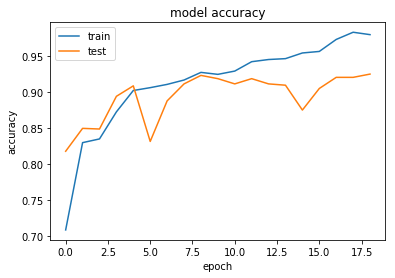

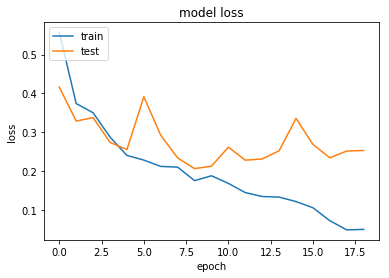

In [14]:
import matplotlib.pyplot as plt
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [15]:
score = model.evaluate(Xtrain, Ytrain, verbose=1)
print('Train score:', score[0])
print('Train accuracy:', score[1])

1471/1471 [==============================] - 9s 6ms/step
Train score: 0.019018755417524815
Train accuracy: 0.9966009517335146


In [5]:
df_test = pd.read_json('./data/test.json')
df_test.inc_angle = df_test.inc_angle.replace('na',0)
Xtest = (get_scaled_imgs(df_test))
pred_test = model.predict(Xtest)

submission = pd.DataFrame({'id': df_test["id"], 'is_iceberg': pred_test.reshape((pred_test.shape[0]))})
print(submission.head(10))

submission.to_csv('submission.csv', index=False)

         id  is_iceberg
0  5941774d    0.086221
1  4023181e    0.964286
2  b20200e4    0.000228
3  e7f018bb    0.998940
4  4371c8c3    0.952687
5  a8d9b1fd    0.044089
6  29e7727e    0.069483
7  92a51ffb    0.998899
8  c769ac97    0.000001
9  aee0547d    0.000039
